In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### SEIR Model Equations

The SEIR model is defined by the following system of differential equations:


\begin{aligned}
\frac{dS}{dt} &= \mu N -\frac{\beta S I}{N} + \omega R - \mu S \\
\frac{dE}{dt} &= \frac{\beta S I}{N} - \sigma E - \mu E  \\
\frac{dI}{dt} &= \sigma E - \gamma I - (\mu + \alpha)I \\
\frac{dR}{dt} &= \gamma I - \omega R - \mu R
\end{aligned}


Where:
- \( S \): Susceptible population
- \( E \): Exposed population (infected but not yet infectious)
- \( I \): Infectious population
- \( R \): Recovered population
- \( $\beta$ \): Transmission rate, the rate at which susceptible individuals become exposed.
- \( $\sigma$ \): Rate at which exposed individuals become infectious (\(1/\text{latent period}\)).
- \( $\gamma$ \): Recovery rate (\(1/\text{infectious period}\)).
- \( $\mu$ \): Background death rate, representing mortality from causes other than the disease.
- \( $\alpha$ \): Disease-induced death rate, representing additional mortality caused by the disease.
- \( $\omega$ \): Immunity loss rate, the rate at which recovered individuals lose immunity and return to the susceptible group.
- \( N \): Total population size (\(N = S + E + I + R\)).

---

### Key Dynamics

- **Latent Period:** Infected individuals first move to the exposed group (\(E\)) at a rate proportional to \(\frac{\beta S I}{N}\). They remain in this group for an average period of \(1/\sigma\) before becoming infectious (\(I\)).
- **Temporary Immunity:** After recovery, individuals return to the susceptible group (\(S\)) after an average protected period of \(1/\omega\).
- **Demography:** All compartments are influenced by background death at a rate \(\mu\), with births replenishing the susceptible population. Disease-induced deaths reduce the infectious population at a rate \(\alpha\).


## Parameters and Initialization Overview

### Initial Conditions
- **Susceptible ($S_0$):** Initial proportion of the population at risk.
- **Exposed ($E_0$):** Initial proportion exposed but not yet infectious.
- **Infectious ($I_0$):** Initial proportion infectious.
- **Recovered ($R_0$):** Initial proportion immune or recovered.

### Effects of Parameter Changes
- **Higher \($\beta$\):** Faster spread, earlier peak.
- **Higher \($\sigma$\):** Shorter latency, quicker epidemic dynamics.
- **Higher \($\gamma$\):** Faster recovery, lower peak infectious population.
- **Higher \($\omega$\):** Faster loss of immunity, leading to a larger susceptible population and potential reinfections.
- **Higher \($\mu$\):** Higher background death rate, decreasing the total population size and slowing epidemic growth due to reduced susceptibles.
- **Higher \($\alpha$\):** Increased disease-induced mortality, reducing the infectious population and increasing the severity of the disease's impact.


This setup defines the SEIR model dynamics and how parameters influence epidemic behavior.


In [9]:
## Parameters ---- DUMMY DATA, needs to change
#
beta = 0.3     # Infection rate
sigma = 1/5    # Incubation rate (1/average latent period)
gamma = 1/7    # Recovery rate (1/average infectious period)
omega = 1/180  # Immunity loss rate (1/average duration of immunity)
mu = 1/(70*365) # Background death rate (assuming an average lifespan of 70 years)
alpha = 0.01   # Disease-induced death rate
dt = 0.1       # Time step
t_max = 100    # Maximum time

## Initial conditions
#
S0, E0, I0, R0 = 0.99, 0.01, 0, 0  # Initial proportions of S, E, I, R
X0 = np.array([S0, E0, I0, R0])   # Initial state vector

## Time array
#
time = np.arange(0, t_max, dt)   # Time steps for simulation

### The Dynamics Matrix $A(\mathbf{X})$

The matrix $A(\mathbf{X})$ encodes the time-dependent dynamics of the SEIRS model, including immunity loss, background mortality, and disease-induced deaths. Each row corresponds to a differential equation for the compartments $S$, $E$, $I$, and $R$:

\begin{equation}
A(\mathbf{X}) =
\begin{bmatrix}
-\beta I - \mu & 0       & 0            & \omega \\
 \beta I       & -\sigma - \mu & 0       & 0 \\
 0             & \sigma  & -\gamma - \mu - \alpha & 0 \\
 0             & 0       & \gamma      & -\omega - \mu
\end{bmatrix}
\end{equation}


- **Nonlinear Terms:** The matrix handles nonlinear interactions like \(-\beta S I / N\) by dynamically depending on \(I\).
- **Purpose:** It allows compact and efficient computation of SEIRS dynamics using matrix multiplication.
- **Rows:**
  - **Row 1:** Susceptible dynamics (\( \frac{dS}{dt} = \mu N - \frac{\beta S I}{N} + \omega R - \mu S \)).
  - **Row 2:** Exposed dynamics (\( \frac{dE}{dt} = \frac{\beta S I}{N} - \sigma E - \mu E \)).
  - **Row 3:** Infectious dynamics (\( \frac{dI}{dt} = \sigma E - \gamma I - (\mu + \alpha) I \)).
  - **Row 4:** Recovered dynamics (\( \frac{dR}{dt} = \gamma I - \omega R - \mu R \)).


In [10]:
def compute_A(X):
    S, E, I, R = X
    return np.array([
        [-beta * I - mu,     0,          0,           omega],
        [ beta * I,     -sigma - mu,     0,           0],
        [      0,           sigma, -gamma - mu - alpha, 0],
        [      0,             0,         gamma, -omega - mu],
    ])

# Euler's Method

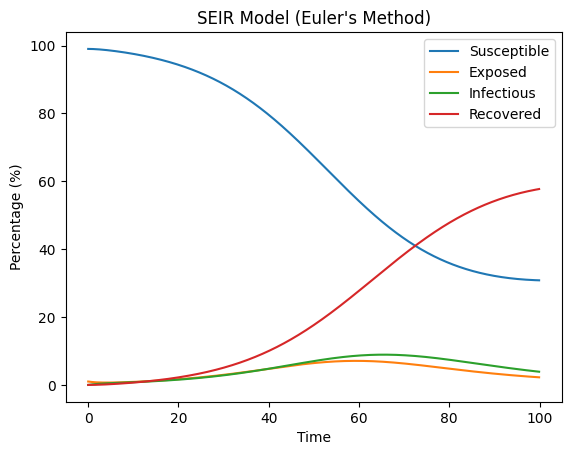

In [11]:
result_euler = np.zeros((len(time), 4)) 
result_euler[0, :] = X0  

for t in range(1, len(time)):
    A = compute_A(result_euler[t-1, :])
    result_euler[t, :] = result_euler[t-1, :] + dt * A @ result_euler[t-1, :]

plt.plot(time, result_euler[:, 0]*100, label='Susceptible')
plt.plot(time, result_euler[:, 1]*100, label='Exposed')
plt.plot(time, result_euler[:, 2]*100, label='Infectious')
plt.plot(time, result_euler[:, 3]*100, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Percentage (%)')
plt.legend()
plt.title("SEIR Model (Euler's Method)")
plt.show()


# RK4 Method

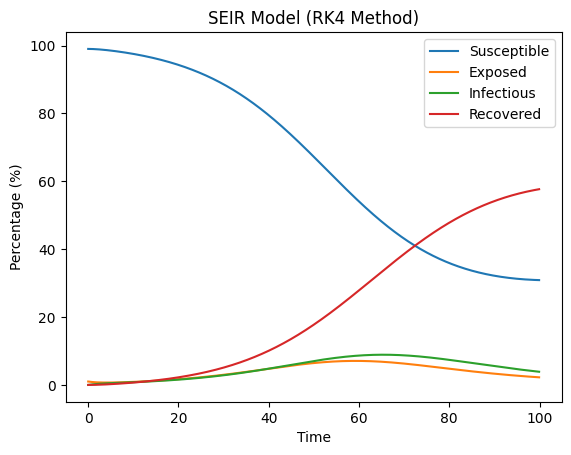

In [12]:
result_rk4 = np.zeros((len(time), 4))
result_rk4[0, :] = X0 

for t in range(1, len(time)):
    X_t = result_rk4[t-1, :]
    
    # Compute k1, k2, k3, k4 using matrix multiplication
    A1 = compute_A(X_t)
    k1 = A1 @ X_t

    A2 = compute_A(X_t + 0.5 * dt * k1)
    k2 = A2 @ (X_t + 0.5 * dt * k1)

    A3 = compute_A(X_t + 0.5 * dt * k2)
    k3 = A3 @ (X_t + 0.5 * dt * k2)

    A4 = compute_A(X_t + dt * k3)
    k4 = A4 @ (X_t + dt * k3)

    result_rk4[t, :] = X_t + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

plt.plot(time, result_rk4[:, 0]*100, label='Susceptible')
plt.plot(time, result_rk4[:, 1]*100, label='Exposed')
plt.plot(time, result_rk4[:, 2]*100, label='Infectious')
plt.plot(time, result_rk4[:, 3]*100, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Percentage (%)')
plt.legend()
plt.title('SEIR Model (RK4 Method)')
plt.show()


In [13]:
result_euler

array([[9.90000000e-01, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00],
       [9.89996125e-01, 9.79996086e-03, 2.00000000e-04, 0.00000000e+00],
       [9.89986311e-01, 9.60986326e-03, 3.92941292e-04, 2.85714286e-06],
       ...,
       [3.08291882e-01, 2.25946862e-02, 3.91946769e-02, 5.76699736e-01],
       [3.08248562e-01, 2.25052061e-02, 3.90472986e-02, 5.76937014e-01],
       [3.08206788e-01, 2.24161021e-02, 3.89003841e-02, 5.77172054e-01]])

In [14]:
result_rk4

array([[9.90000000e-01, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00],
       [9.89993190e-01, 9.80486427e-03, 1.96521236e-04, 1.41168355e-06],
       [9.89980646e-01, 9.61927138e-03, 3.86283151e-04, 5.58061649e-06],
       ...,
       [3.08904459e-01, 2.25737276e-02, 3.91124002e-02, 5.76197466e-01],
       [3.08861669e-01, 2.24848110e-02, 3.89660900e-02, 5.76432738e-01],
       [3.08820412e-01, 2.23962667e-02, 3.88202387e-02, 5.76665792e-01]])